In [16]:
import numpy as np
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [17]:
actions = [
    'One', 'Two', 'Three','Four','Five','Six','Seven','Eight','Nine','Zero'
]

data = np.concatenate([
    np.load('/content/seq_One_1649252839.npy'),
    np.load('/content/seq_Two_1649252839.npy'),
    np.load('/content/seq_Three_1649252839.npy'),                   
    np.load('/content/seq_Four_1649252839.npy'),
    np.load('/content/seq_Five_1649252839.npy'),                   
    np.load('/content/seq_Six_1649252839.npy'),
    np.load('/content/seq_Seven_1649252839.npy'),
    np.load('/content/seq_Eight_1649252839.npy'),                   
    np.load('/content/seq_Nine_1649252839.npy'),
    np.load('/content/seq_Zero_1649252839.npy')
], axis=0)

data.shape

(4017, 30, 140)

In [18]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(4017, 30, 139)
(4017,)


In [19]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(4017, 10)

In [20]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3615, 30, 139) (3615, 10)
(402, 30, 139) (402, 10)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(20, activation='relu'),
    
    
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                52224     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 20)                660       
                                                                 
 dense_25 (Dense)            (None, 10)                210       
                                                                 
Total params: 55,174
Trainable params: 55,174
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=275,
    callbacks=[
        ModelCheckpoint('models/model_pose3.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/275
112/113 [============================>.] - ETA: 0s - loss: 2.4689 - acc: 0.4470
Epoch 1: val_acc improved from -inf to 0.73383, saving model to models/model_pose3.h5
113/113 [==============================] - 4s 26ms/step - loss: 2.4545 - acc: 0.4498 - val_loss: 0.8422 - val_acc: 0.7338 - lr: 0.0010
Epoch 2/275
113/113 [==============================] - ETA: 0s - loss: 0.3603 - acc: 0.8982
Epoch 2: val_acc improved from 0.73383 to 0.98010, saving model to models/model_pose3.h5
113/113 [==============================] - 3s 23ms/step - loss: 0.3603 - acc: 0.8982 - val_loss: 0.1142 - val_acc: 0.9801 - lr: 0.0010
Epoch 3/275
112/113 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9685
Epoch 3: val_acc did not improve from 0.98010
113/113 [==============================] - 3s 24ms/step - loss: 0.1226 - acc: 0.9685 - val_loss: 0.1487 - val_acc: 0.9527 - lr: 0.0010
Epoch 4/275
111/113 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9893
Epoch 

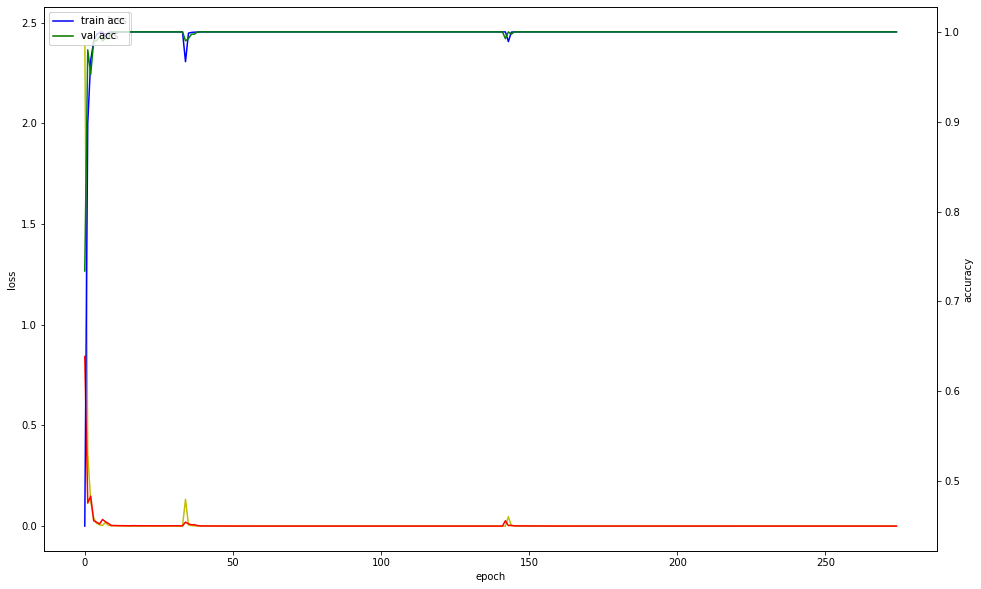

In [23]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [25]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('models/model_pose3.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

array([[[358,   0],
        [  0,  44]],

       [[360,   0],
        [  0,  42]],

       [[378,   0],
        [  0,  24]],

       [[355,   0],
        [  0,  47]],

       [[359,   0],
        [  0,  43]],

       [[362,   0],
        [  0,  40]],

       [[371,   0],
        [  0,  31]],

       [[355,   0],
        [  0,  47]],

       [[358,   0],
        [  0,  44]],

       [[362,   0],
        [  0,  40]]])